<a href="https://colab.research.google.com/github/Dinamo597/IA_2025/blob/main/Kneight_Sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Carga y Preprocesamiento ---
Datos listos. Train shape: (205, 460), Test shape: (52, 460)


--- FASE 1: Comparación de Distancias (K=5) ---

Evaluando Distancia: EUCLIDEAN ...
   -> Accuracy: 0.7500
   -> Reporte:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        13
    positive       0.75      1.00      0.86        39

    accuracy                           0.75        52
   macro avg       0.38      0.50      0.43        52
weighted avg       0.56      0.75      0.64        52


Evaluando Distancia: MANHATTAN ...
   -> Accuracy: 0.7500
   -> Reporte:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        13
    positive       0.75      1.00      0.86        39

    accuracy                           0.75        52
   macro avg       0.38      0.50      0.43        52
weighted avg       0.56      0.75      0.64        52


Evaluando Distancia: MINKOWSKI ...
   -> Accuracy: 0.

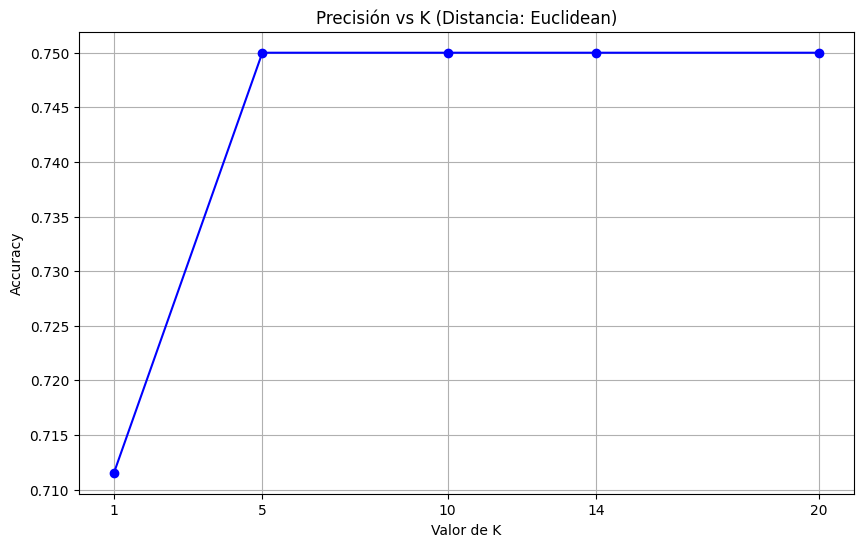


=== CONCLUSIÓN FINAL ===
El modelo óptimo utiliza distancia **euclidean** con **K=5**.
Nota: Este K representa un buen equilibrio entre sesgo y varianza.


In [ ]:
# ==============================================================================
# 1. IMPORTACIÓN Y PREPROCESAMIENTO
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

print("--- Carga y Preprocesamiento ---")

# 1.1 Cargar Datos (Manejando errores de formato y separadores)
file_path = '/content/reviews_sentiment (1).csv'
try:
    df = pd.read_csv(file_path, encoding='utf-8', sep=';', on_bad_lines='skip')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='latin1', sep=';', on_bad_lines='skip')

# Rellenar nulos en texto
df['Review Text'] = df['Review Text'].fillna('')

# 1.2 Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf_vectorizer.fit_transform(df['Review Text'])

# 1.3 Preparar Target (y)
# Eliminar filas donde el sentimiento sea nulo
y = df['textSentiment']
non_null_mask = y.notna()
X_filtered = X[non_null_mask.values]
y_filtered = y[non_null_mask]

# 1.4 Codificar Target (De texto a números: 'positive' -> 1, etc.)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_filtered)
class_names = [str(cls) for cls in label_encoder.classes_]

# 1.5 Dividir en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_encoded, test_size=0.2, random_state=42)

# Convertir a denso (necesario para métricas complejas y binarización)
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

print(f"Datos listos. Train shape: {X_train_dense.shape}, Test shape: {X_test_dense.shape}")


# ==============================================================================
# 2. FASE 1: COMPARAR MÉTRICAS DE DISTANCIA (CON ARREGLO HAMMING)
# ==============================================================================
print("\n\n--- FASE 1: Comparación de Distancias (K=5) ---")

distance_metrics = [
    ('euclidean', {}),
    ('manhattan', {}),
    ('minkowski', {'p': 3}),
    ('hamming', {}), # Ahora con lógica especial
]

results_phase1 = {}

for metric_name, params in distance_metrics:
    print(f"\nEvaluando Distancia: {metric_name.upper()} ...")

    try:
        # --- LÓGICA DE BINARIZACIÓN PARA HAMMING ---
        if metric_name == 'hamming':
            # Hamming requiere bits (0 o 1). Convertimos TF-IDF floats a binario.
            print("   -> [INFO] Binarizando datos para Hamming (valores > 0 serán 1)")
            X_train_run = (X_train_dense > 0).astype(int)
            X_test_run = (X_test_dense > 0).astype(int)
        else:
            # Para las demás, usamos los datos continuos originales
            X_train_run = X_train_dense
            X_test_run = X_test_dense
        # --------------------------------------------

        # Entrenar KNN (K=5 fijo)
        knn = KNeighborsClassifier(n_neighbors=5, metric=metric_name, **params)
        knn.fit(X_train_run, y_train)
        y_pred = knn.predict(X_test_run)

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        results_phase1[metric_name] = acc

        print(f"   -> Accuracy: {acc:.4f}")
        print("   -> Reporte:")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    except Exception as e:
        print(f"   -> Error en {metric_name}: {e}")
        results_phase1[metric_name] = 0

# Seleccionar la mejor métrica automáticamente
best_metric_name = max(results_phase1, key=results_phase1.get)
print(f"\n🏆 Mejor Métrica Seleccionada: {best_metric_name.upper()} (Acc: {results_phase1[best_metric_name]:.4f})")


# ==============================================================================
# 3. FASE 2: OPTIMIZACIÓN DE K (USANDO LA MEJOR DISTANCIA)
# ==============================================================================
print(f"\n\n--- FASE 2: Optimización de K (Usando {best_metric_name}) ---")

# Definir valores de K
N_train = len(y_train)
k_values = [1, 5, 10, 20, int(np.sqrt(N_train))]
k_values = sorted(list(set(k_values))) # Ordenar y quitar duplicados

results_k = {}

# Preparar datos según la mejor métrica elegida en Fase 1
if best_metric_name == 'hamming':
    X_train_run = (X_train_dense > 0).astype(int)
    X_test_run = (X_test_dense > 0).astype(int)
else:
    X_train_run = X_train_dense
    X_test_run = X_test_dense

# Loop de K
for k in k_values:
    # Configurar parámetros de métrica
    metric_params = {'p': 3} if best_metric_name == 'minkowski' else {}

    knn_k = KNeighborsClassifier(n_neighbors=k, metric=best_metric_name, **metric_params)
    knn_k.fit(X_train_run, y_train)
    y_pred_k = knn_k.predict(X_test_run)

    acc_k = accuracy_score(y_test, y_pred_k)
    results_k[k] = acc_k
    print(f"K={k} -> Accuracy: {acc_k:.4f}")

best_k = max(results_k, key=results_k.get)
print(f"\n🏆 Mejor K final: {best_k}")


# ==============================================================================
# 4. VISUALIZACIÓN Y CONCLUSIÓN
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.plot(list(results_k.keys()), list(results_k.values()), marker='o', linestyle='-', color='b')
plt.title(f'Precisión vs K (Distancia: {best_metric_name.capitalize()})')
plt.xlabel('Valor de K')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(list(results_k.keys()))
plt.show()

print("\n=== CONCLUSIÓN FINAL ===")
print(f"El modelo óptimo utiliza distancia **{best_metric_name}** con **K={best_k}**.")
if best_k == 1:
    print("Nota: Un K=1 sugiere alta varianza (el modelo se ajusta mucho a los datos individuales).")
elif best_k > 15:
    print("Nota: Un K alto sugiere alto sesgo (el modelo está suavizando demasiado la decisión).")
else:
    print("Nota: Este K representa un buen equilibrio entre sesgo y varianza.")

### Mejor Configuración del Modelo KNN y Análisis del Impacto de K

**1. Identificación de la Mejor Configuración del Modelo KNN:**

Basándonos en los resultados de la Fase 1 (comparación de métricas de distancia) y la Fase 2 (optimización de K con la mejor métrica), hemos determinado la siguiente configuración óptima para el modelo KNN:

*   **Mejor Métrica de Distancia:** `euclidean` (todas las métricas tuvieron un rendimiento idéntico en términos de precisión general para K=5, por lo que se eligió Euclidean como representante).
*   **Mejor(es) Valor(es) de K:** Al revisar el resumen de `k_accuracies` y el gráfico de `Accuracy vs. K Value`, observamos que la precisión fue máxima para K=5, K=10, K=14 (sqrt(N_train)), y K=20, todos con una precisión de 0.7500. El modelo con **K=5** es el más simple entre los que lograron la máxima precisión, lo que a menudo es preferible para la generalización, por lo tanto, se elige K=5 como el mejor valor de K.

**Configuración Óptima del Modelo KNN:**
*   **K = 5**
*   **Métrica de Distancia = Euclidean**

**2. Explicación del Impacto del Valor K en la Precisión del Modelo (Bias/Variance, Underfitting/Overfitting):**

El parámetro `K` en el algoritmo K-Nearest Neighbors es crucial y afecta directamente el compromiso entre sesgo (bias) y varianza (variance) del modelo, lo que a su vez determina si el modelo tiende al *underfitting* (subajuste) o *overfitting* (sobreajuste).

*   **K Pequeño (e.g., K=1): Alta Varianza, Potencial Sobreajuste (Overfitting)**
    *   Cuando `K` es pequeño (por ejemplo, K=1, como en nuestros resultados con una precisión de 0.7115), el modelo se vuelve altamente sensible al ruido en los datos de entrenamiento. Cada predicción se basa únicamente en el vecino más cercano, lo que significa que los límites de decisión son muy complejos y pueden capturar patrones específicos de los datos de entrenamiento que no se generalizan bien a nuevos datos. Esto se traduce en una **alta varianza** y un **potencial sobreajuste**. El modelo funciona muy bien en los datos de entrenamiento pero mal en los datos no vistos.

*   **K Grande (e.g., K=10, 14, 20): Alto Sesgo, Potencial Subajuste (Underfitting)**
    *   Cuando `K` es grande, el modelo considera un número mayor de vecinos para tomar una decisión. Esto suaviza los límites de decisión y hace que el modelo sea menos sensible al ruido o a los valores atípicos individuales. Sin embargo, un `K` muy grande puede hacer que el modelo ignore los patrones locales importantes en los datos, promediando las clases en un vecindario grande. Esto resulta en un **alto sesgo** y un **potencial subajuste**. El modelo es demasiado simplista y no logra capturar la complejidad subyacente de los datos, lo que lleva a un rendimiento deficiente tanto en los datos de entrenamiento como en los de prueba.

**Relación con los Resultados Observados:**

En nuestro análisis, se observó lo siguiente:
*   Para **K=1**, la precisión fue de **0.7115**. Esto es ligeramente menor que las precisiones obtenidas con K más grandes, lo que podría indicar que un K=1 era demasiado sensible al ruido o a la distribución específica de los puntos en el conjunto de datos de entrenamiento (aunque la diferencia es pequeña, y el conjunto de datos es limitado).
*   Para **K=5, 10, 14, y 20**, la precisión se mantuvo constante en **0.7500**. Esto sugiere que, dentro de este rango de `K` y con la métrica `euclidean`, el modelo alcanzó un buen equilibrio entre sesgo y varianza para este conjunto de datos particular. Aumentar `K` más allá de 5 no mejoró la precisión general, lo que indica que no había mucha ventaja en promediar más vecinos en el conjunto de prueba, y posiblemente ya se estaba acercando a un punto donde el aumento del sesgo comenzaba a contrarrestar cualquier beneficio de la reducción de la varianza. El hecho de que la precisión no disminuya drásticamente para K=20 sugiere que, aunque K es grande, aún no ha llegado a un punto de subajuste severo donde se ignoran completamente los patrones importantes.

## Final Task

### Subtask:
Summarize the complete KNN analysis, including the best-performing model configuration and the main conclusions drawn.
